# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше 

Всю работу можно моделить на несколько шагов:
1. [Знакомство с данными](#1)
2. [Обработка данных](#2)
3. [Анализ данных](#3)
4. [Проверка гипотез](#4)
5. [Вывод по проекту](#5)

## 1  
# Знакомство с данными

In [1]:
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import math

from scipy import stats as st
import numpy as np

In [2]:
users = pd.read_csv('/datasets/users.csv')
users = users.set_index('user_id')
display(users.head())
users.info()

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(1), object(6)
memory usage: 31.2+ KB


In [3]:
calls = pd.read_csv('/datasets/calls.csv')
display(calls.head())
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
messages = pd.read_csv('/datasets/messages.csv')
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [5]:
internet = pd.read_csv('/datasets/internet.csv')
display(internet.head())
internet = internet.set_index('Unnamed: 0')
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [6]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs = tariffs.set_index('tariff_name')
display(tariffs.head())
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
tariff_name,,,,,,,
smart,50,15360,500,550,200,3,3
ultra,1000,30720,3000,1950,150,1,1


<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, smart to ultra
Data columns (total 7 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
dtypes: int64(7)
memory usage: 128.0+ bytes


В данном блоке были подключены необходимые библиотеки и изучены данные в таблицах и типы полей

## 2 
# Обработка данных

In [7]:
# выделение звонков с длительностью не 0 и округление в большую сторону на 1
calls = calls.query('duration != 0')
calls.loc[calls['duration'] % 1 > 0, 'duration'] = (calls.loc[calls['duration'] % 1 > 0, 'duration'] + 1)
calls['duration'] = calls['duration'].astype('int')

# создание поля со значением месяцев
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['month'] = calls['call_date'].dt.month

#calls_m = calls.groupby(['user_id', 'month'])['duration'].sum()
calls_m = calls.pivot_table(index=['user_id', 'month'], values = 'duration', aggfunc = 'sum')

In [8]:
# создание поля со значением месяцев
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['month'] = messages['message_date'].dt.month

#messages_m = messages.groupby(['user_id', 'month'])['message_date'].count()
messages_m = messages.pivot_table(index=['user_id', 'month'], values = 'message_date', aggfunc = 'count')

In [9]:
# выделение расхода трафика не 0
internet = internet.query('mb_used != 0')
internet.loc[internet['mb_used'] % 1 > 0, 'mb_used'] = (internet.loc[internet['mb_used'] % 1 > 0, 'mb_used'] + 1)
internet['mb_used'] = internet['mb_used'].astype('int')

# создание поля со значением месяцев
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet['month'] = internet['session_date'].dt.month

#internet_m = internet.groupby(['user_id', 'month'])['mb_used'].sum()
internet_m = internet.pivot_table(index=['user_id', 'month'], values = 'mb_used', aggfunc = 'sum')

In [10]:
# объединение таблиц в 1 с мультииндексом user_id и month для дальнейшей обработки
data = calls_m.join(internet_m, how = 'outer' )
data = data.join(messages_m, how = 'outer')
data = data.fillna(0)
data = data.join(users['tariff'], on = 'user_id')
data.columns = ['minutes_spoke', 'mb_used', 'message_wrote', 'tariff_name' ]
data = data.join(tariffs, on ='tariff_name')
display(data.head())

minutes_spoke  mb_used  message_wrote tariff_name  \
user_id month                                                      
1000    5              159.0   2256.0           22.0       ultra   
        6              172.0  23257.0           60.0       ultra   
        7              340.0  14016.0           75.0       ultra   
        8              408.0  14070.0           81.0       ultra   
        9              466.0  14581.0           57.0       ultra   

               messages_included  mb_per_month_included  minutes_included  \
user_id month                                                               
1000    5                   1000                  30720              3000   
        6                   1000                  30720              3000   
        7                   1000                  30720              3000   
        8                   1000                  30720              3000   
        9                   1000                  30720              3000   

               rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute  
user_id month                                                                
1000    5                 1950         150                1               1  
        6                 1950         150                1               1  
        7                 1950         150                1               1  
        8                 1950         150                1               1  
        9                 1950         150                1               1

In [11]:
def income_func(row):
    income = row['rub_monthly_fee']
    if row['minutes_spoke'] > row['minutes_included']:
        income = income + (row['minutes_spoke'] - row['minutes_included']) * row['rub_per_minute']
    if row['mb_used'] > row['mb_per_month_included']:
        income = income + math.ceil((row['mb_used'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']
    if row['message_wrote'] > row['messages_included']:
        income = income + (row['message_wrote'] - row['messages_included']) * row['rub_per_message']
    return income

data['total_income'] = data.apply(income_func, axis = 1)

Из таблицы звонков были удалены записи с продолжительностью 0 секунд, по причине того, что они не используются в расчетах, так как такие звонки бесплатны. Я их связываю с тем, что многие люди скидывают свой звонок с расчетом на то, что им перезвонят, люди не хотят тратить бесплатные минуты или выходить, перплачивать за тариф.

По итогам обработки данных была получена таблица data с данными об использовании пользователями ресурсов мобильного оператора по тарифам ultra и smart. Была получена ежемесячная выручка с каждого пользователя.

## 3 
# Анализ данных

In [12]:
#получение выборок по каждому тарифу
ultra_data = data.query('tariff_name == "ultra"')
smart_data = data.query('tariff_name == "smart"')

#таблица со средним значением полей
mean_data = data.groupby('tariff_name')[['minutes_spoke', 'mb_used', 'message_wrote']].mean()

#расчеты дисперсии
minutes_variance_ultra = np.var(ultra_data['minutes_spoke'])
mb_variance_ultra = np.var(ultra_data['mb_used'])
message_variance_ultra = np.var(ultra_data['message_wrote'])
minutes_variance_smart = np.var(smart_data['minutes_spoke'])
mb_variance_smart = np.var(smart_data['mb_used'])
message_variance_smart = np.var(smart_data['message_wrote'])

#добавление полей о дисперсии и стандартного отклонения в mean_data
mean_data['minutes_variance'] = [minutes_variance_smart, minutes_variance_ultra]
mean_data['mb_variance'] = [mb_variance_smart, mb_variance_ultra]
mean_data['message_variance'] = [message_variance_smart, message_variance_ultra]
mean_data['minutes_std'] = [math.sqrt(minutes_variance_smart), math.sqrt(minutes_variance_ultra)]
mean_data['mb_std'] = [math.sqrt(mb_variance_smart), math.sqrt(mb_variance_ultra)]
mean_data['message_std'] = [math.sqrt(message_variance_smart), math.sqrt(message_variance_ultra)]

mean_data = round(mean_data,2)

display(mean_data)

,minutes_spoke,mb_used,message_wrote,minutes_variance,mb_variance,message_variance,minutes_std,mb_std,message_std
tariff_name,,,,,,,,,
smart,417.93,16229.19,33.38,36203.07,3.453041e+07,796.46,190.27,5876.26,28.22
ultra,526.62,19486.90,49.36,100771.22,1.018321e+08,2282.95,317.44,10091.19,47.78


Получена таблица с информацией о среднем, дисперсии и стандартном отклонении полей minutes_spoke, mb_used, message_wrote для 2 тарифов отдельно. Из этой таблицы можно сделать вывод, что пользователи тарифа ultra пользуются мобильным оператором чаще других, но это и понятно, так как они получают больше бесплатных минут, мбайт и сообщений, хоть и платят больше.

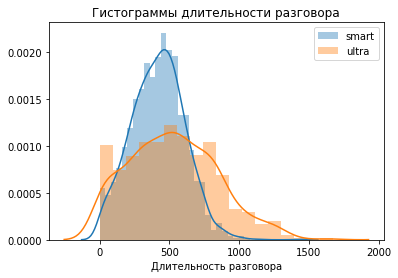

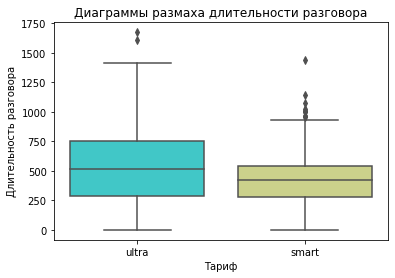

In [13]:
# получение гистограммы и диаграммы размаха для 2 тарифов по длительности разговора
ax =  sns.distplot(smart_data['minutes_spoke'], hist = True)
sns.distplot(ultra_data['minutes_spoke'], ax = ax, axlabel ='Длительность разговора')
plt.title('Гистограммы длительности разговора')
plt.legend(labels = ['smart', 'ultra'])
plt.show()
sns.boxplot(data = data, x ='tariff_name', y = 'minutes_spoke', palette = 'rainbow' )
plt.title('Диаграммы размаха длительности разговора')
plt.xlabel('Тариф')
plt.ylabel('Длительность разговора')
plt.show()

Из диаграммы размаха и гистограммы по длительности разговора делаем вывод, что разброс длительности у пользователей тарифа ultra шире и медиана больше, чем у smart.

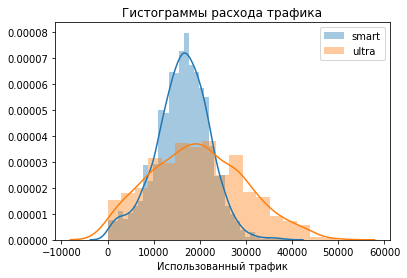

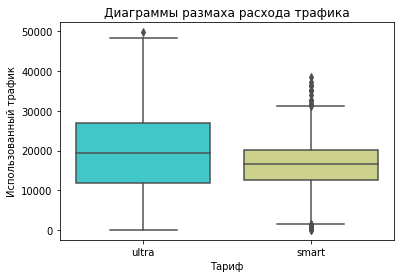

In [14]:
# получение гистограммы и диаграммы размаха для 2 тарифов по интернет-трафику
ax =  sns.distplot(smart_data['mb_used'], hist = True)
sns.distplot(ultra_data['mb_used'], ax = ax, axlabel ='Использованный трафик')
plt.title('Гистограммы расхода трафика')
plt.legend(labels = ['smart', 'ultra'])
plt.show()
sns.boxplot(data = data, x ='tariff_name', y = 'mb_used', palette = 'rainbow'  )
plt.title('Диаграммы размаха расхода трафика')
plt.xlabel('Тариф')
plt.ylabel('Использованный трафик')
plt.show()

Из диаграммы размаха и гистограммы по расходу трафика делаем вывод, что у пользователеи тарифа ultra сидят в интернете дольше, это видно из медианы и расположению самих коробок. Кроме этого, видно что у пользователей тарифа smart диапозон значений не такой большой как у пользователей ultra.

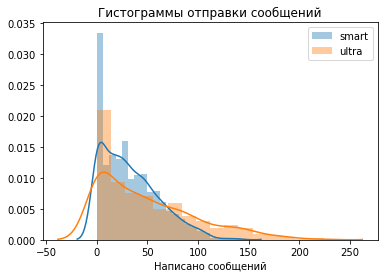

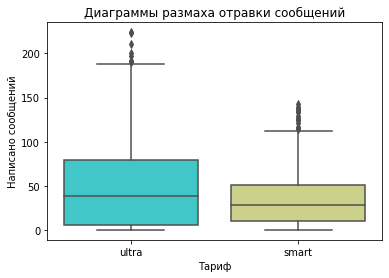

In [15]:
# получение гистограммы и диаграммы размаха для 2 тарифов по количеству сообщений
ax =  sns.distplot(smart_data['message_wrote'], hist = True)
sns.distplot(ultra_data['message_wrote'], ax = ax, axlabel ='Написано сообщений')
plt.title('Гистограммы отправки сообщений')
plt.legend(labels = ['smart', 'ultra'])
plt.show()
sns.boxplot(data = data, x ='tariff_name', y = 'message_wrote', palette = 'rainbow'  )
plt.title('Диаграммы размаха отравки сообщений')
plt.xlabel('Тариф')
plt.ylabel('Написано сообщений')
plt.show()

Из диаграммы размаха и гистограммы по количеству сообщений получаем, что в обоих тарифах есть пользователи, которые почти не переписываются, это видно из того, что коробка почти стоит на 0 отметке. Но нельзя не отметить, что у части пользователей тарифа ultra  количество сообщений превышает 150, когда у ползователей smart чуть больше 100.

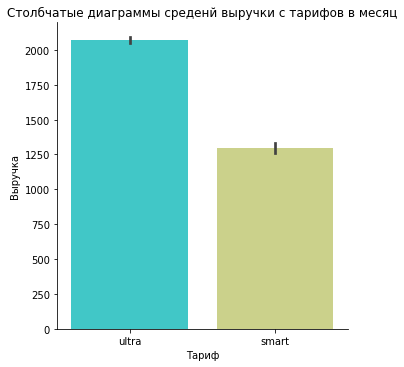

In [16]:
sns.catplot(x = 'tariff_name', y = 'total_income', kind = 'bar', data = data, palette = 'rainbow' )
plt.title('Столбчатые диаграммы среденй выручки с тарифов в месяц')
plt.xlabel('Тариф')
plt.ylabel('Выручка')
plt.show()

Из столбчатых диаграмм были получены данные, по которым можно увидеть, что пользователи тарифа smart выходят за рамки тарифа очень часто, они платят больше чем 2 ежемесячной оплаты тарифа. Когда пользователи ultra  если выходят из тарифа, то не больше чем на 100 - 200 реблей.

## 4
# Проверка гипотез

#### Гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Нулевая гипотеза: средняя выручка тарифов «Ультра» и «Смарт» одинакова.

In [17]:
# сравнени дисперсий выручки с тарифов
smart_variance = np.var(smart_data['total_income']) 
ultra_variance = np.var(ultra_data['total_income']) 
print('Дисперсия smart - ', smart_variance)
print('Дисперсия ultra - ', ultra_variance)

Дисперсия smart -  673628.974426787
Дисперсия ultra -  143345.5641732588


Дисперсии выборок считать равными нельзя. Следовательно, equal_var = False.

In [18]:
#cоздание 2 выборок по тарифам


# критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
alpha = 0.05

results = st.ttest_ind(smart_data['total_income'], ultra_data['total_income'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


Отвергам гипотезу: средняя выручка тарифов «Ультра» и «Смарт» одинакова.

#### Гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза: средняя выручка пользователей из Москвы и пользователей из других регионов однаковы.

In [19]:
# получение данных о пользователях с информацией о городах
data_city = data.join(users['city'], on ='user_id')

# получение 2 выборок: по Москве, по другим городам
data_city_moscow = data_city.query('city == "Москва"')
data_city_other = data_city.query('city != "Москва"')

In [20]:
moscow_variance = np.var(data_city_moscow['total_income']) 
other_variance = np.var(data_city_other['total_income']) 
print('Дисперсия по Москве - ', moscow_variance)
print('Дисперсия по другим городам - ', other_variance)

Дисперсия по Москве -  565256.3794161058
Дисперсия по другим городам -  656514.2841040562


Дисперсии выборок считать равными нельзя. Следовательно, equal_var = False

In [21]:
# критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
alpha = 0.05

results = st.ttest_ind(data_city_moscow['total_income'], data_city_other['total_income'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


P-значение равно 0.51, следовательно, мы не можем сказать отвергнуть гипотезу, что средняя выручка пользователей из Москвы и пользователей из других регионов однаковы. С вероятностью 50% различия выручки пользователей из Москвы и пользователей с других городов случайны.

## 5 
# Вывод

В ходе проекта были выполнены следующие пункты и получены результаты:
    1. были подключены необходимые библиотеки и изучены данные в таблицах и типы полей
    2. Из таблицы звонков были удалены записи с продолжительностью 0 секунд, по причине того, что они не используются в расчетах, так как такие звонки бесплатны. Я их связываю с тем, что многие люди скидывают свой звонок с расчетом на то, что им перезвонят, люди не хотят тратить бесплатные минуты или выходить, перплачивать за тариф
    3. По итогам обработки данных была получена таблица data с данными об использовании пользователями ресурсов мобильного оператора по тарифам ultra и smart. Была получена ежемесячная выручка с каждого пользователя.
    4. Получена таблица с информацией о среднем, дисперсии и стандартном отклонении полей minutes_spoke, mb_used, message_wrote для 2 тарифов отдельно. Из этой таблицы можно сделать вывод, что пользователи тарифа ultra пользуются мобильным оператором чаще других, но это и понятно, так как они получают больше бесплатных минут, мбайт и сообщений, хоть и платят больше.
    5. Из диаграммы размаха и гистограммы по длительности разговора делаем вывод, что разброс длительности у пользователей тарифа ultra шире и медиана больше, чем у smart.
    6. Из диаграммы размаха и гистограммы по расходу трафика делаем вывод, что у пользователеи тарифа ultra сидят в интернете дольше, это видно из медианы и расположению самих коробок. Кроме этого, видно что у пользователей тарифа smart диапозон значений не такой большой как у пользователей ultra
    7. Из диаграммы размаха и гистограммы по количеству сообщений получаем, что в обоих тарифах есть пользователи, которые почти не переписываются, это видно из того, что коробка почти стоит на 0 отметке. Но нельзя не отметить, что у части пользователей тарифа ultra количество сообщений превышает 150, когда у ползователей smart чуть больше 100.
    8. Из столбчатых диаграмм были получены данные, по которым можно увидеть, что пользователи тарифа smart выходят за рамки тарифа очень часто, они платят больше чем 2 ежемесячной оплаты тарифа. Когда пользователи ultra если выходят из тарифа, то не больше чем на 100 - 200 реблей.

Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается:
    1. Отвергам гипотезу: средняя выручка тарифов «Ультра» и «Смарт» одинакова
Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов:
    2. P-значение равно 0.51, следовательно, мы не можем сказать отвергнуть гипотезу, что средняя выручка пользователей из Москвы и пользователей из других регионов однаковы. С вероятностью 50% различия выручки пользователей из Москвы и пользователей с других городов случайны.